In [ ]:
# python standard library imports
# from-imports follow regular imports
import re
import random
from math import sqrt
from collections import Counter
import datetime

# external libraries imports, grouped semantically
import torch
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import clear_output, display


# Word2vec tutorial

In this tutorial we will implement text pre-processing in a matte that is similar to how we pre-process text for neural networks and then we will train out own word vectors on our own dataset.

## Task 1
Find a dataset to train your word embeddings on. It should be more than 50 000 words after the pre-processing is done. To make the dataset you can use absolutely any text: wikipedia, movie scripts, books, reddit, twitter. The kinds of text you are using will affect your word embeddings flavor. You can use the same dataset we used in the class, but we encourage you to make your own dataset.

Useful links:

1. Learn more about python list comprehensions: https://www.programiz.com/python-programming/list-comprehension
1. Numerical instability of softmax: https://www.youtube.com/watch?v=99qLd2p6x5E

In [ ]:
# authenticate to google drive

# reference https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# get the twitter data from cwinsor's google drive

# ID of the twitter data on google drive
fid_rd = "1LdRLJCHHlfyifj36Ti8QDVq9LB9XNEkw"
drive_file = drive.CreateFile({'id': fid_rd})

# Download the file to a local disc
local_filename = "covid_tweets.txt"
drive_file.GetContentFile(local_filename)

In [ ]:
# open and read the file
f = open(local_filename, "r")
raw_data = f.read()
print("length of raw data (bytes): ", len(raw_data))

length of raw data (bytes):  1379824


In [ ]:
print(raw_data[:1000])

RT @SenTomCotton: The coronavirus has become a global pandemic, yet the Chinese Communist Party continues to play politics by blocking Taiw… RT @mediocregandhi: Massive respect for the medical team Loving my new ball stretcher https://t.co/PGr3OuLglO 完全にビクター･ザーズにハマりました😇😇😇 RT @ThobeArsenal: Sweden confirmed its first case of novel #coronavirus in Jönköping, central-southern Sweden on Fri, according to the Swed… Normala Sister talkin of viability gap funding , PPP for creating more hospitals , medical backbone 

But Government of India 🇮🇳 asking @adgpi &amp; sister orga with scarce resources to prepare to battle #coronavirus 

#Budget2020 

@fayedsouza 10s of orgs set up for emergencies 🤣😭 RT @ShefVaidya: Can’t believe this guy is the president of Pakistan, telling the poor Pakistani students stuck in #Wuhan to fend for themse… RT @meyer_lucas: Dr. Chris Mackie says she wore masks from Wuhan to Canada, and went straight into home isolation even before she showed sy… * Oh Everything's gon

# Preprocessing

In [ ]:
def preprocess(text):
    text = text.lower()

    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)

    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)
    return text


In [ ]:
preprocessed_data = preprocess(raw_data)
preprocessed_data[:1000]

'rt sentomcotton the coronavirus has become a global pandemic yet the chinese communist party continues to play politics by blocking taiw rt mediocregandhi massive respect for the medical team loving my new ball stretcher httpstcopgr3oulglo 完全にビクターザーズにハマりました rt thobearsenal sweden confirmed its first case of novel coronavirus in jönköping centralsouthern sweden on fri according to the swed normala sister talkin of viability gap funding ppp for creating more hospitals medical backbone but government of india asking adgpi amp sister orga with scarce resources to prepare to battle coronavirus budget2020 fayedsouza 10s of orgs set up for emergencies rt shefvaidya cant believe this guy is the president of pakistan telling the poor pakistani students stuck in wuhan to fend for themse rt meyer_lucas dr chris mackie says she wore masks from wuhan to canada and went straight into home isolation even before she showed sy oh everythings gonna be ok あなたがいなくても everythings gonna be ok 元気でね 分かりきったストー

In [ ]:
def tokenize(text):
    return text.split(" ")

tokenized_data = tokenize(preprocessed_data)

print(f"Total number of words : {len(tokenized_data)}")
print(f"Number of unique words: {len(set(tokenized_data))}")
print(f"First 10 words", tokenized_data[:10])

Total number of words : 201871
Number of unique words: 21988
First 10 words ['rt', 'sentomcotton', 'the', 'coronavirus', 'has', 'become', 'a', 'global', 'pandemic', 'yet']


In [ ]:
word_counts = Counter(tokenized_data)
word_counts.most_common(10)

[('the', 9411),
 ('rt', 7882),
 ('coronavirus', 4952),
 ('in', 4686),
 ('to', 4593),
 ('a', 3955),
 ('of', 3777),
 ('is', 2466),
 ('and', 2442),
 ('china', 2420)]

In [ ]:
# least common
word_counts.most_common()[:-10-1:-1]

[('', 1),
 ('alarabiya_eng', 1),
 ('ozcrimenews', 1),
 ('httpstcomhyd5ci8ax', 1),
 ('httpstcouejsirjksp', 1),
 ('httpstcosdgvzvumih', 1),
 ('httpstcokfuzckonjl', 1),
 ('tx', 1),
 ('stoopid', 1),
 ('doubly', 1)]

In [ ]:
rare_words = []
for word, count in word_counts.items():
    if count < 4:
        rare_words.append(word)

len(rare_words)

17897

After looking at the resulting word vectors I decided to remove some of the most frequent words too. While in general it is not a good idea, it words well for this homework.

In [ ]:
frequent_words = ["rt", "the", "and", "a", "to", "of", "in", "his", "you", "is", "on", "i", "as", "he", "it", "at", "with", "into", "out", "him", "from", "for", "that", "be", "your", "by", "this", "an"]

In [ ]:
vocabulary = set(tokenized_data) - set(rare_words) - set(frequent_words)
len(vocabulary)

4063

In [ ]:
filtered_data = [w for w in tokenized_data if w in vocabulary]

print("Total number of words in the dataset after filtration: ", len(filtered_data))
assert len(filtered_data) > 50_000, "your dataset should have at least 50K words"

Total number of words in the dataset after filtration:  125307


# Word2vec idea:

Maximize in-context word similarity, while minimizing out-of-context word vector similarity.

Spefcifically:

$$
maximize \frac{e^{w \cdot w_{in context}}}{\sum e^{ w \cdot w_{out of context}}}
$$

In [ ]:
window_size = 6

In [ ]:
filtered_data[110:130]
# word: spacecraft, context: [tiny, silver, a, rebel]

['stuff',
 'still',
 'not',
 'think',
 'twice',
 'correct',
 'myself',
 'im',
 '21',
 'shes',
 'way',
 'ahead',
 'ireland',
 'up',
 '500',
 'people',
 'die',
 'flu',
 'each',
 'year']

In [ ]:
words_and_contexts = []  # list of tuples (word, list of context words)

for i, word in enumerate(filtered_data):
    if i < window_size:
        continue
    if i >= len(filtered_data) - window_size:
        break

    context = []
    for j in range(i - window_size, i + window_size + 1):
        if i == j: continue
        context.append(filtered_data[j])
    
    word_and_context = (word, context)
    words_and_contexts.append(word_and_context)

random.shuffle(words_and_contexts)
words_and_contexts[0]

('minutes',
 ['test',
  'can',
  'detect',
  'coronavirus',
  '8',
  '15',
  'tests',
  'can',
  'made',
  'arslan_crickter',
  'she',
  'volunteer'])


# (Too) simple (and too slow) word2vec implementation

```python
emb_size = 50

word2vec = dict()
for w in vocabulary:
    word2vec[w] = torch.randn(emb_size, requires_grad=True)
    
# training loop

for word, context in tqdm(words_and_contexts):
    word_vector = word2vec[word]
    context_vector = sum([word2vec[w] for w in context]) / len(context)

    nominator = torch.exp(word_vector @ context_vector.T)
    denominator = sum(torch.exp(word_vector @ word2vec[w].T) for w in vocabulary)

    loss = - nominator / denominator

    # update our word vectors using gradient descent to minimize loss
    # 1. compute gradients
    # 2. update vectors in the direction opposite to the gradient

    loss.backward()  # compute gadients

    with torch.no_grad():
        for w in word2vec.values():
            w -= w.grad
            w.grad = None

# TOO SLOW: one pass over data takes more than an hour!
```

# More realistic word2vec example

We going to change a couple of things from the naive implementation:

1. Use a single embedding matrix instead of a dicrionary `word2vec` that maps words to their vectors
2. Use matrix multiplication instead of for-loop

These two things will speed up computation by a factor of a hundred.

3. Use a numerically stable implementation of the loss function.

4. Update our vectors with a gradient averaged over 100 examples instead of a gradient of just one example.

5. Initialize word vectors with smaller numbers.

6. Carefully select **learning rate** parameter of gradient descent.

These four things (3-6) will help us to optimize word vectors without them becoming NaN.

7. We are going to train for longer to get better vectors

### About numerical stability

Remember that our loss looks like this:

$$
loss = -log \frac{e^{w \cdot c}}{\sum e^{w \cdot w_i}}
$$

which is basically a softmax operation

$$
softmax(x) = \frac{e^{x}}{\sum e^{x_i}}
$$

And naive implementation of softmax causes NaN when computed on large numbers. Watch [the video](https://youtu.be/99qLd2p6x5E?t=92) to understand why.

If you prefer reading to watching the videos, you can take a look at this [Stanford CS231n class note](https://cs231n.github.io/linear-classify/#softmax-classifier). Look for "Practical issues: Numeric stability".

### About word vector initialization

In the next lectures we will discuss why it's beneficial to initialize parameters like randn(size) / sqrt(size).
Short answer: large numbers cause divergences in optimization process. Meaning you loss goes to infinity or NaN which is just as bad. When you multiply two random vectors of size S distributed N(0, 1) you get a vector distribted N(0, S). To make this smaller we initialize vectors from $N(0, 1/S) = N(0, 1) / \sqrt{S}$ which gives us N(0, 1).



In [ ]:
word2id = {}
for idx, word in enumerate(vocabulary):
    word2id[word] = idx


def numerically_stable_loss(word_vector, context_vector, all_word_vectors):
    word_context_sim = word_vector @ context_vector.T
    word_vocab_sim = word_vector @ all_word_vectors.T

    # --- important part that makes computation numerically stable ---
    max_value = torch.max(word_vocab_sim)
    word_context_sim_normalized = word_context_sim - max_value
    word_vocab_sim_normalized = word_vocab_sim - max_value
    # ----------------------------------------------------------------

    nominator = torch.exp(word_context_sim_normalized)
    denominator = torch.sum(torch.exp(word_vocab_sim_normalized))

    loss = -torch.log(nominator / denominator)
    return loss

## Task 2:

This training loop is already working, your task is to understand how it works and to find `learning_rate` that gives you the best vectors in terms of the training loss. Also feel free to modify `emb_size`, `max_epochs` and `batch_size`, but usually learning rate is the most important parameter. Reasonable range for learning rate (in this specific case) is 1e-4 to 1.0, but feel free to try values outsize of that range as well.

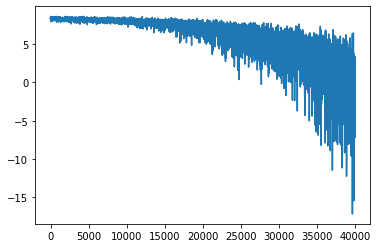

Grad is None. Updating the vectors now will cause them to become NaN. Interrupting training.
Epoch 1
2023-02-08 02:23:28.123443
Training finished


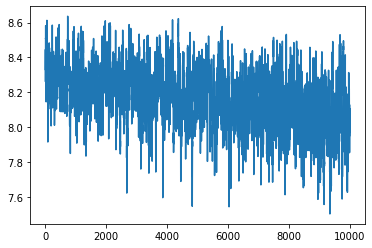

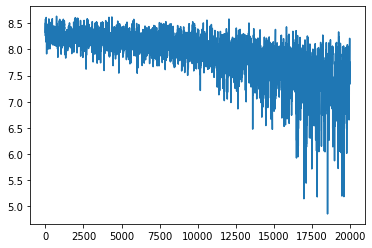

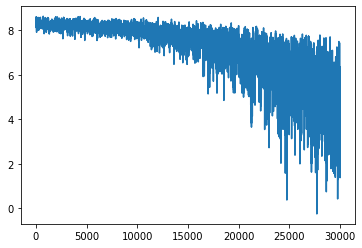

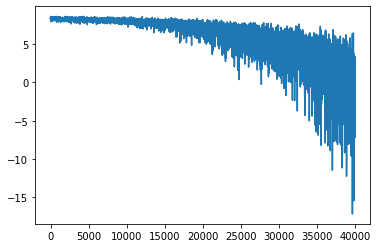

In [ ]:
emb_size = 50
learning_rate = 1e-1

vocab_size = len(vocabulary)
batch_size = 100

word_embeddings_init_value = np.random.randn(vocab_size, emb_size) / sqrt(emb_size)
word_embeddings = torch.tensor(word_embeddings_init_value, requires_grad=True, dtype=torch.float32)

global_step = 0

prev_loss_value = None
loss_hist = []
should_stop = False

start = datetime.datetime.now()
print(start)

for epoch in range(5):
    random.shuffle(words_and_contexts)  # shuffle the dataset
    print(f"Epoch {epoch}")
    if should_stop: break

    for word, context in tqdm(words_and_contexts):
        global_step += 1

        word_idx = word2id[word]
        context_idx = [word2id[w] for w in context]

        word_vector = word_embeddings[word_idx]
        context_vector = sum(word_embeddings[context_idx])

        loss = numerically_stable_loss(word_vector, context_vector, word_embeddings)

        # compute gadients at every step
        # every loss.backward() adds to the previous gradients
        # using multiple examples to get the gradient allows us to better estimate the true gradient over the whole dataset
        loss.backward()

        # ####### ZONA #########3
        # if (abs(loss)<0.01):
        #   # print(type(loss))
        #   # print(loss.shape)
        #   # print(loss)
        #   loss = torch.randn(1)
        #   # print(type(loss))
        #   # print(loss.shape)
        #   # print(loss)
        #   # assert False, 'done here'

        if torch.isnan(loss).item():
            print("Loss is None. Updating the vectors now will cause them to become NaN. Interrupting training.")
            should_stop = True
            break

        if global_step % batch_size == 0:
            with torch.no_grad():
                if torch.any(torch.isnan(word_embeddings.grad)):
                    print("Grad is None. Updating the vectors now will cause them to become NaN. Interrupting training.")
                    should_stop = True
                    break

                gradient = word_embeddings.grad
                gradient = gradient / batch_size  # average gradients over batch_size examples
                gradient = gradient.clamp(min=-5.0, max=5.0)  # fancy deep learning hack that we will learn in the next lectures
                word_embeddings -= learning_rate * gradient

                # zero out the gradients
                word_embeddings.grad = torch.zeros_like(word_embeddings.grad)

        if prev_loss_value is None:
            prev_loss_value = loss

        loss_to_log = loss * 0.1 + prev_loss_value * 0.9  # exponential smoohting to make the plots look nicer
        prev_loss_value = loss_to_log
        loss_hist.append(loss_to_log.item())  # .item() converts a single-value tensor to a regular python float

        if global_step % 10_000 == 0:
            # plots the loss so you can observe if it goes down or not
            clear_output()  # this will cause tqdm to disappear, sorry
            fig, ax = plt.subplots(1, 1)
            ax.plot(loss_hist)
            display(fig)

end = datetime.datetime.now()
print(end)
print("Training finished")

**More about task 2** We expect your loss to significantly decrease during training which should be visible on the plot above.

In [ ]:
# Play with trained vectors

def get_word_vector(word_str):
    if word_str not in word2id:
        raise ValueError(f"Word {word_str} not in the vocabulary")
    
    return word_embeddings[word2id[word_str]]

In [ ]:
pandemic = get_word_vector("pandemic")
market = get_word_vector("market")
wuhan = get_word_vector("wuhan")
china = get_word_vector("china")
virus = get_word_vector("virus")

In [ ]:
# compute similarity
wuhan @ wuhan.T

tensor(17.1093, grad_fn=<DotBackward0>)

In [ ]:
# compute similarity of luke with luke
wuhan @ market.T

tensor(0.2564, grad_fn=<DotBackward0>)

In [ ]:
# compute similarity of the word luke with the word force
china @ virus.T

tensor(7.5385, grad_fn=<DotBackward0>)

In [ ]:
# compute similarity of the word luke with the word force
virus @ china.T

tensor(7.5385, grad_fn=<DotBackward0>)

## Task 3:

Use word embeddings to find most similar words to these words:

1. luke
1. woman
1. star

If the above words are not in your vocabulary, feel free to use different ones.


> Because the dataset is small, it's likely that most similar words won't be perfect. Feel free to train on more data (get a bigger dataset).


To find most similar words to a word W compute the similarity with the rest of the words from the vocabulary. Print top-10 most similar words: most similar to least and the similarity value like this:

```
luke most similar:
luke similarity: 18.753528594970703
han similarity: 17.64794921875
leia similarity: 16.81419563293457
threepio similarity: 14.953056335449219
int similarity: 14.128015518188477
cockpit similarity: 12.512998580932617
star similarity: 11.790962219238281
artoo similarity: 11.107627868652344
chewie similarity: 10.742396354675293
death similarity: 10.645984649658203
```

In [ ]:
# YOUR CODE HERE
with torch.no_grad():

  # make a lookup from id to word
  id2word = {}
  for word in vocabulary:
    id = word2id[word]
    id2word[id] = word

  # compute similarity - word to word

  # # similarity by dot product
  # all_similarity = torch.matmul(word_embeddings, word_embeddings.T)

  # cosine similarity
  cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
  all_similarity_list = cos(word_embeddings.unsqueeze(1), word_embeddings)
  all_similarity = torch.Tensor(all_similarity_list)
  
  # # L2 distance similarity
  # pdist = torch.nn.PairwiseDistance(p=2)
  # all_similarity_list = pdist(word_embeddings.unsqueeze(1), word_embeddings)
  # all_similarity = -torch.Tensor(all_similarity_list)

  # # L1 distance similarity
  # pdist = torch.nn.PairwiseDistance(p=1)
  # all_similarity_list = pdist(word_embeddings.unsqueeze(1), word_embeddings)
  # all_similarity = -torch.Tensor(all_similarity_list)

  # method to print the N highest similarity for given word...
  def print_n_most_similar(n, word):
    word_id=word2id[word]
    similarity_argsort = torch.argsort(all_similarity[word_id], descending=True)
    # similarity_top_names = [id2word[x.item()] for x in similarity_argsort[:n]]
    # similarity_top_valus = [all_similarity[0,0] for x in similarity_argsort[:n]]
    print("'{}' most similar:".format(word))
    for similar_id in similarity_argsort[:n]:
      print("  ", id2word[similar_id.item()], all_similarity[word_id, similar_id.item()].item())

  print_n_most_similar(8, "wuhan")
  print_n_most_similar(8, "virus")
  print_n_most_similar(8, "originated")
  print_n_most_similar(8, "cases")
  print_n_most_similar(8, "medical")
  print_n_most_similar(8, "workers")



'wuhan' most similar:
   wuhan 1.0
   coronavirus 0.9694837331771851
   china 0.9558047652244568
   outbreak 0.9160103797912598
   has 0.9086664319038391
   cases 0.8891982436180115
   are 0.8709136247634888
   who 0.8652759194374084
'virus' most similar:
   virus 1.0
   all 0.8168122172355652
   wuhan 0.7993543744087219
   coronavirus 0.7827981114387512
   china 0.7624830603599548
   outbreak 0.7391413450241089
   cases 0.7380921840667725
   6 0.7379975318908691
'originated' most similar:
   originated 0.9999998807907104
   petition 0.49106258153915405
   philanthropist 0.4263044595718384
   tears 0.40089040994644165
   packing 0.3979145288467407
   disaster 0.39716267585754395
   httpstcomhhbzoihra 0.38911956548690796
   tourists 0.38473257422447205
'cases' most similar:
   cases 1.0
   coronavirus 0.9158944487571716
   china 0.8963125944137573
   wuhan 0.8891982436180115
   has 0.8687401413917542
   outbreak 0.8490909934043884
   are 0.839073121547699
   confirmed 0.8320111036300659

# Submission instructions

As in the first homework, execute the notebook top-to-bottom and submit it to the blackboard.